In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import KFold
import os
import time
from sklearn import metrics

In [2]:
def get_model(vocab_size, len): 
    initializer = tf.keras.initializers.GlorotNormal()
    regularizer = tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)
    model = tf.keras.Sequential();
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=128, input_length=len))
    model.add(tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(16, return_sequences=False, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [3]:
from os import listdir
from os.path import isfile, join
from dataclasses import dataclass


@dataclass
class File:
    name: str
    path: str
    lines: list
    label: int
    
    
def readfile(filename):
    with open(filename) as file:
        lines = [line.rstrip()  for line in file if line.strip()]
    return lines


def readdir(dirname):
    files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
    return files


def fileFactory(filename, directory, label):
    fullpath = join(directory, filename)
    return File(filename, fullpath, readfile(fullpath), label)

In [4]:
fp_dir = '.\git\hacka_2024\FalsePositive'
tp_dir = '.\git\hacka_2024\TruePositive'

In [5]:
from enum import IntEnum


class labels(IntEnum):
    truePositive  = 0
    falsePositive = 1

tp_file_names = readdir(tp_dir)
fp_file_names = readdir(fp_dir)

print(tp_file_names)
print(fp_file_names)

tp_files = list()
fp_files = list()

for f in tp_file_names:   
    tp_files.append( fileFactory(f, tp_dir, labels.truePositive) );
   
for f in fp_file_names:   
    fp_files.append( fileFactory(f, fp_dir, labels.falsePositive) );
print(len(tp_files))
print(len(fp_files))

['Abc.java', 'Abs.java', 'AnotherClass1.java', 'AnotherExample5.java', 'AnotherTest4.java', 'AnotherTestClass4.java', 'Auth.java', 'BillieJean.java', 'ByteClass1.java', 'ByteClass3.java', 'ByteComparasion5.java', 'ByteExample2.java', 'CharClass1.java', 'CharClass3.java', 'CharComparison5.java', 'Check.java', 'CustomClass2.java', 'CustomClass4.java', 'CustomTest1.java', 'CustomTest2.java', 'DemoClass.java', 'DemoClassOne.java', 'DemoClassTwo.java', 'DifferentClass6.java', 'DoubleClass1.java', 'DoubleClass3.java', 'DoubleComparison5.java', 'Du.java', 'Example1.java', 'Example2.java', 'Example3.java', 'Example4.java', 'Example5.java', 'ExampleChar2.java', 'ExampleClass2.java', 'ExampleClass3.java', 'ExampleClassTwo.java', 'ExampleDouble2.java', 'ExampleFloat2.java', 'ExampleInt2.java', 'ExampleLong2.java', 'ExampleOne.java', 'ExampleOneOne.java', 'ExampleShort2.java', 'FIfthComparator.java', 'FirstComparator.java', 'FloatClass1.java', 'FloatClass3.java', 'FloatComparison5.java', 'FourthCo

In [34]:
for line in tp_files[0].lines:
    print(line)

public class Abc {
    Object pqr;
    Object ghi;
    public boolean xyz(Abc jkl) {
        if (!(pqr == jkl.pqr && ghi == jkl.ghi))
            return false;
        else
            return true;
    }
}


In [39]:
syntax = {
    "{" : 1,
    "}" : 2,
    ";" : 3,
    "(" : 4,
    ")" : 5,
    "[" : 6,
    "]" : 7,
    "<" : 8,
    ">" : 9
}

keytokens = {
    "abstract" : 0,
    "do" : 0,
    "if" : 0,
    "package" : 0,	
    "synchronized" : 0,
    "implements" : 0,	
    "private" : 0,
    "this" : 0,
    "break": 0,
    "else" : 0,
    "import" : 0,
    "protected" : 0,
    "throw" : 0,
    "extends" : 0,
    "instanceof" : 0,
    "public" : 0,
    "throws" : 0,
    "case" : 0,
    "false" : 0,
    "return" : 0,
    "catch" : 0,
    "final" : 0,
    "interface" : 0,
    "short" : 0,
    "true" : 0,
    "finally" : 0,
    "static" : 0,
    "try" : 0,
    "class" : 0,
    "native" : 0,
    "strictfp" : 0,
    "const" : 0,
    "for" : 0,
    "new" : 0,
    "super" : 0,
    "continue" : 0,
    "goto" : 0,
    "null" : 0,
    "switch" : 0,
    "while" : 0,
    "default" : 0,
    "assert" : 0,
}

buildin_types = {
    "boolean" : 0,
    "double" : 0,
    "float" : 0,
    "long" : 0,
    "char" : 0,
    "int" : 0,
    "void" : 0,
    "byte" : 0,
}

wrapper_types = {
    "Byte" : 0,
    "Short" : 0,
    "Integer" : 0,
    "Long" : 0,
    "Float" : 0,
    "Double" : 0,
    "Boolean" : 0,
    "Character" : 0
}



from collections import namedtuple
from enum        import IntEnum

class TokenType(IntEnum):
    Comment = 0
    Syntax  = 1
    Keyword = 40
    Library = 100
    BuildinType = 200
    StringLiteral = 500
    ReferenceType = 2000
    Unknown = 5000


Token  = namedtuple('Token', ['type', 'value'])

def determine_type(value):
    if   value in syntax:
        return TokenType.Syntax
    elif value in keytokens:
        return TokenType.Keyword
    elif value in buildin_types:
        return TokenType.BuildinType
    elif value in wrapper_types:
        return TokenType.ReferenceType
    else:
        return TokenType.Unknown
    

class ParsingError(Exception):
    def __init__(self, message):            
        super().__init__(message)

class UsageError(Exception):
    def __init__(self, message):            
        super().__init__(message)

class  PreParser:
    def __init__(self, file_name):
        self.tokens = []
        self.value  = ""
        self.type   = TokenType.Unknown
        self.char   = 0
        self.file   = open(file_name)

    def __enter__(self):
        return self
    
    def __exit__(self, type, value, traceback):
        self.file.close()

    def get_result(self):
        return self.tokens
    
    def read_next_char(self):
        self.char = self.file.read(1)
        return self.char

    def peel_next_char(self):
        saved_char = self.char
        if not self.read_next_char():
            self.char, saved_char = saved_char, ''
        else:
            self.char, saved_char = saved_char, self.char
        self.file.seek(self.file.tell() - 1, 0)
        return saved_char

    def end_token(self):
        if not self.value:
            return False
        self.tokens.append( Token(self.type if self.type != TokenType.Unknown else determine_type(self.value), self.value) )
        self.value = ""
        self.type = TokenType.Unknown
        return True

    def is_comment_start(self):
        next_char = self.peel_next_char()
        if next_char == '/' or next_char == '*':
            return True
        return False

    def collapse_comment(self):
        comment = ""
        if   self.char == '/':
            while self.read_next_char():
                if self.char == '\n':
                    self.value = comment
                    self.type  = TokenType.Comment
                    return       
                comment += self.char
        elif self.char == '*':
            while self.read_next_char():
                if self.char == '*':
                    self.read_next_char()
                    self.value = comment
                    self.type  = TokenType.Comment
                    return
                comment += self.char
        else:
            UsageError("PreParser.collapse_comments() shall be called when self.char is on the second symbol of an opening comment sequence.")
        raise ParsingError("Comment is not closed.")
    
    def collapse_string(self):
        string = ""
        while self.read_next_char():
            if self.char == '"':
                self.value = string
                self.type  = TokenType.StringLiteral
                return
            string += self.char
        raise ParsingError("String literal is not closed.")

    
    def parse(self):
        while self.read_next_char():
            if self.char.isspace():
                self.end_token()
                continue
 
            if(self.char in syntax):
                self.end_token()
                self.value = self.char
                self.end_token()
                continue

            if(self.char == '"'):
                self.collapse_string()
                self.end_token()
                continue

            if(self.char == "/"):
                if not self.is_comment_start():
                    continue
                self.read_next_char()
                self.collapse_comment()
                self.end_token()
                continue

            self.value += self.char
        else:
            self.end_token()   

class Parser:
    def __init__(self, tokens):
        self.tokens  = tokens
        self.result = []
        self.known_user_types = {};

    def __enter__(self):
        return self
    
    def __exit__(self, type, value, traceback):
        (...)

    def get_result(self):
        return self.result
    
    def is_class(self, token):
        return token.value == 'class'
    
    def remember_class(self, token):
        self.known_user_types[token.value] = True

    def is_know_type(self, t):
        return t.value in self.known_user_types
    
    def parse(self):
        for idx, t in enumerate(self.tokens):
            if self.is_class(t):
                self.remember_class( self.tokens[idx + 1] )


        for t in self.tokens:
            if  self.is_know_type(t):
                self.result.append( Token(TokenType.ReferenceType, t.value) )
            else:
                self.result.append(t)

In [35]:
tp_files[0].path

'.\\git\\hacka_2024\\TruePositive\\Abc.java'

In [36]:
tp_files[1].lines

['import java.util.Set;',
 'public class Abs {',
 '    Set<String> words;',
 '    public boolean complete(Abs second) {',
 '        return !words != second.words;',
 '    }',
 '}']

In [38]:
file_path = tp_files[1].path
tokens = []
with PreParser(file_path) as preparser:
    preparser.parse()
    with Parser( preparser.get_result() ) as parser:
        parser.parse()
        for value in parser.get_result():
            print(value)
            tokens.append(value)

Token(type=<TokenType.Keyword: 40>, value='import')
Token(type=<TokenType.Unknown: 5000>, value='java.util.Set')
Token(type=<TokenType.Syntax: 1>, value=';')
Token(type=<TokenType.Keyword: 40>, value='public')
Token(type=<TokenType.Keyword: 40>, value='class')
Token(type=<TokenType.ReferenceType: 2000>, value='Abs')
Token(type=<TokenType.Syntax: 1>, value='{')
Token(type=<TokenType.Unknown: 5000>, value='Set')
Token(type=<TokenType.Syntax: 1>, value='<')
Token(type=<TokenType.Unknown: 5000>, value='String')
Token(type=<TokenType.Syntax: 1>, value='>')
Token(type=<TokenType.Unknown: 5000>, value='words')
Token(type=<TokenType.Syntax: 1>, value=';')
Token(type=<TokenType.Keyword: 40>, value='public')
Token(type=<TokenType.BuildinType: 200>, value='boolean')
Token(type=<TokenType.Unknown: 5000>, value='complete')
Token(type=<TokenType.Syntax: 1>, value='(')
Token(type=<TokenType.ReferenceType: 2000>, value='Abs')
Token(type=<TokenType.Unknown: 5000>, value='second')
Token(type=<TokenType.

In [11]:
def create_unique_vocabulary(tokens):
    result = []
    for token in tokens:
        if (all(result_token.value != token.value for result_token in result)):
            result.append(token)
    return result

In [12]:
create_unique_vocabulary(tokens)

[Token(type=<TokenType.Keyword: 40>, value='import'),
 Token(type=<TokenType.Unknown: 5000>, value='java.util.Set'),
 Token(type=<TokenType.Syntax: 1>, value=';'),
 Token(type=<TokenType.Keyword: 40>, value='public'),
 Token(type=<TokenType.Keyword: 40>, value='class'),
 Token(type=<TokenType.ReferenceType: 2000>, value='Abs'),
 Token(type=<TokenType.Syntax: 1>, value='{'),
 Token(type=<TokenType.Unknown: 5000>, value='Set'),
 Token(type=<TokenType.Syntax: 1>, value='<'),
 Token(type=<TokenType.Unknown: 5000>, value='String'),
 Token(type=<TokenType.Syntax: 1>, value='>'),
 Token(type=<TokenType.Unknown: 5000>, value='words'),
 Token(type=<TokenType.BuildinType: 200>, value='boolean'),
 Token(type=<TokenType.Unknown: 5000>, value='complete'),
 Token(type=<TokenType.Syntax: 1>, value='('),
 Token(type=<TokenType.Unknown: 5000>, value='second'),
 Token(type=<TokenType.Syntax: 1>, value=')'),
 Token(type=<TokenType.Keyword: 40>, value='return'),
 Token(type=<TokenType.Unknown: 5000>, valu

In [ ]:
def create_vocabulary_with_weights(tokens):
    vocabulary_without_weights = create_unique_vocabulary(tokens)
    for unique_token in vocabulary_without_weights:
        #TODO: create_weight_to_token
    

    

In [ ]:
from tokenize_all import Java


#doesn't work with labmda-expression
def generateSimpleDictionary(lines): 
    tokens = [];
    
    #ignore whitespace
    for line in lines: 
        tokens.extend([token for token in Java.tokenize(line) if (token.type != 'whitespace')])
    
    #delete value duplicates
    tokens_set = set(tokens)

    unique_tokens_dict = {obj.value: obj for obj in tokens_set}
    unique_tokens_set = set(unique_tokens_dict)
    return unique_tokens_set

In [13]:
#dictionaryCreator
import re

def generateSimpleDictionary(lines): 
    tokens = [];
    pattern = "[\w']+|[^\w\s']"
    
    for line in lines:
        tokens.extend(re.findall(pattern, line))
        
    #delete value duplicates
    tokens_set = set(tokens)
    return tokens_set


def generateGlobalDictionary(files):
    unique_tokens_dict = set(); 
    for file in files:
        unique_tokens_dict |= generateSimpleDictionary(file.lines)
    return unique_tokens_dict

In [14]:
#numberVectorCreator
#TODO: сделать так, что для неизвестных символов возвращался -1
def generateVector(lines, enumeratedElements): 
    vector = [];
    pattern = "[\w']+|[^\w\s']"
    
    for line in lines:
        tokens = re.findall(pattern, line)
        vector.extend([enumeratedElements.index(token) for token in tokens])
    return vector

In [15]:
dictionary_set = generateGlobalDictionary(tp_files)
dictionary_set |= generateGlobalDictionary(fp_files)
enumerated_dictionary = list(dictionary_set)

In [16]:
def generateTrainData(files, enumerated_dictionary):
    X = []
    y = []
    for file in files: 
        X.append(generateVector(file.lines, enumerated_dictionary))
        y.append(int(file.label))
    return X, y

In [17]:
Xtp, ytp = generateTrainData(tp_files, enumerated_dictionary)
Xfp, yfp = generateTrainData(fp_files, enumerated_dictionary)

In [18]:
Xtp.extend(Xfp)
ytp.extend(yfp)

In [ ]:
len(ytp)

In [19]:
n_splits = 5

In [ ]:
def cross_validation(n_splits, X, y, vocabulary, epochs): 
    X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', value=-1)
    X = np.array(X)
    y = np.array(y)
    random_ = 42
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_)

    y_real = []
    X_real = []
    y_pred = []

    for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
        print(f"Fold #{fold}")     
        train_x = X[train_index]
        train_y = y[train_index]  
        test_x = X[test_index]
        test_y = y[test_index] 
        
        checkpoint_filepath = f"./model/cross/checkpoint#{fold}.weights.h5"
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                       save_weights_only=True,
                                                                       monitor='loss',
                                                                       mode='min',
                                                                       save_best_only=True)
        model = get_model(len(vocabulary), train_x.shape[1])
        history = model.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y), callbacks=[model_checkpoint_callback])
        model.load_weights(checkpoint_filepath)
        predictions = model.predict(test_x)
        X_real.extend(test_x)
        y_real.extend(test_y)
        y_pred.extend(predictions)
    return X_real, y_real, y_pred

In [33]:
def cheater_cross_validation(n_splits, X, y, vocabulary, epochs):
    X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', value=-1)
    X = np.array(X)
    y = np.array(y)
    random_ = 42
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_)

    y_real = []
    X_real = []
    y_pred = []
    for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
        print(f"Fold #{fold}")     
        train_x = X[train_index]
        train_y = y[train_index]  
        test_x = X[test_index]
        test_y = y[test_index] 
        checkpoint_filepath = f"./model/cross/checkpoint#{fold}.weights.h5"
        modelFit(train_x, train_y, vocabulary, epochs, checkpoint_filepath, 0.1)
        model.load_weights(checkpoint_filepath)
        predictions = model.predict(test_x)
        X_real.extend(test_x)
        y_real.extend(test_y)
        y_pred.extend(predictions)
    return X_real, y_real, y_pred

In [ ]:
X_real, y_real, y_pred = cheater_cross_validation(10, Xtp, ytp, enumerated_dictionary, 25)
printResults(y_pred, 0.5, y_real)

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np

#Сюда подается абсолютно вся выборка
def modelFit(X, y, voc, epochs, checkpoint_path, part):
    X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='pre', value=-1)
    X = np.array(X)
    y = np.array(y)

    if (os.path.exists(checkpoint_path)):
        os.remove(checkpoint_path)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=part)
    model = get_model(len(voc), X.shape[1])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[model_checkpoint_callback])
    
    plt.plot(history.history['val_accuracy'], label="val_accuracy")
    plt.plot(history.history['val_loss'], label="val_loss")
    
    plt.legend()
    plt.show()
    return X_train, X_test, y_train, y_test

In [21]:
EPOCHS = 20
batch_size = 2
checkpoint_path = "./model/checkpoint.weights.h5"

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.5055 - loss: 0.8017 - val_accuracy: 0.5417 - val_loss: 0.7886
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.5938 - loss: 0.7812 - val_accuracy: 0.6250 - val_loss: 0.7599
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7413 - loss: 0.7340 - val_accuracy: 0.6250 - val_loss: 0.7226
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8283 - loss: 0.6166 - val_accuracy: 0.8750 - val_loss: 0.5166
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9725 - loss: 0.4301 - val_accuracy: 0.9167 - val_loss: 0.3931
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9692 - loss: 0.3643 - val_accuracy: 0.9167 - val_loss: 0.3909
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9756 - loss: 0.3040 - val_accuracy: 0.9167 - val_loss: 0.3326
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9907 - loss: 0.2521 - val_accuracy: 0.7917 - val_loss:

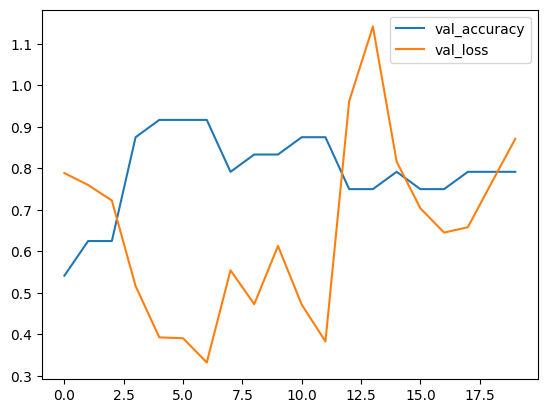

In [30]:
x_train, x_test, y_train, y_test = modelFit(Xtp, ytp, enumerated_dictionary, EPOCHS, checkpoint_path, 0.1)

In [31]:
X = tf.keras.preprocessing.sequence.pad_sequences(Xtp, padding='pre', value=-1)
X = np.array(X)
model = loadModel(checkpoint_path, len(enumerated_dictionary), X.shape[1])
y_pred = model.predict(X)
y_real = ytp
printResults(y_pred, 0.5, y_real)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
TP:  116  TN:  114  FP:  1  FN:  3
Accuracy:  98.29059829059828 %
[0]: 0 - 0
[1]: 0 - 0
[2]: 0 - 0
[3]: 0 - 0
[4]: 0 - 0
[5]: 0 - 0
[6]: 0 - 0
[7]: 0 - 1
[8]: 0 - 0
[9]: 0 - 0
[10]: 0 - 0
[11]: 0 - 0
[12]: 0 - 0
[13]: 0 - 0
[14]: 0 - 0
[15]: 0 - 0
[16]: 0 - 0
[17]: 0 - 0
[18]: 0 - 0
[19]: 0 - 0
[20]: 0 - 0
[21]: 0 - 0
[22]: 0 - 0
[23]: 0 - 0
[24]: 0 - 0
[25]: 0 - 0
[26]: 0 - 0
[27]: 0 - 0
[28]: 0 - 0
[29]: 0 - 0
[30]: 0 - 0
[31]: 0 - 0
[32]: 0 - 0
[33]: 0 - 0
[34]: 0 - 0
[35]: 0 - 0
[36]: 0 - 0
[37]: 0 - 0
[38]: 0 - 0
[39]: 0 - 0
[40]: 0 - 0
[41]: 0 - 0
[42]: 0 - 0
[43]: 0 - 0
[44]: 0 - 0
[45]: 0 - 0
[46]: 0 - 0
[47]: 0 - 0
[48]: 0 - 0
[49]: 0 - 0
[50]: 0 - 0
[51]: 0 - 0
[52]: 0 - 0
[53]: 0 - 0
[54]: 0 - 0
[55]: 0 - 0
[56]: 0 - 0
[57]: 0 - 0
[58]: 0 - 0
[59]: 0 - 1
[60]: 0 - 0
[61]: 0 - 0
[62]: 0 - 0
[63]: 0 - 0
[64]: 0 - 0
[65]: 0 - 0
[66]: 0 - 0
[67]: 0 - 0
[68]: 0 - 0
[69]: 0 - 0
[70]: 0 - 0
[71]: 0 - 0
[72]:

In [ ]:
tp_files[6].lines

In [32]:
file = fp_files[6]
demonstrate(file, checkpoint_path, enumerated_dictionary)

public class ByteClassY {
    byte numberB;
    byte otherNumberB;
    public boolean isEqual(ByteClassY someOtherObject) {
        return numberB == someOtherObject.numberB && otherNumberB == someOtherObject.otherNumberB;
    }
}
Пошла возня, пошли расчеты:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
Ответ шарлатана (ML):
Тут нет ошибки


In [23]:
def demonstrate(file, checkpoint_path, enumerated_dictionary):
    cur_file = file.lines
    y_real = [file.label]
    
    for line in cur_file:
        print(line)
        
    vector = [] 
    vector.append(generateVector(cur_file, enumerated_dictionary))
    
    X = tf.keras.preprocessing.sequence.pad_sequences(vector, padding='pre', value=-1)
    X = np.array(X)

    print("Пошла возня, пошли расчеты:")
    model = loadModel(checkpoint_path, len(enumerated_dictionary), X.shape[1])
    y_pred = model.predict(X)
    
    classVal = getClassFromBinaryClassification(y_pred, 0.5)
    print("Ответ шарлатана (ML):")
    
    if (classVal == 0):
        print("Тут ошибка")
    else: 
        print("Тут нет ошибки")

In [24]:
def loadModel(weight_file, vocabulary_size, shape):
    model = get_model(vocabulary_size, shape)
    l = []
    l.append(list(np.zeros(shape)))
    l = np.array(l)
    model.predict(l)
    model.load_weights(weight_file)
    return model

#Преобразование вероятности в класс
def getClassFromBinaryClassification(value, thresh): 
    if (value > thresh): 
        return 1
    else:
        return 0

#Вычисление параметра точности
def findAccuracy(y_real, y_pred):
    TP = 0;
    TN = 0; 
    FP = 0; 
    FN = 0;
    for i in range(len(y_real)):
        if (y_real[i] == 1):
            if (y_real[i] == y_pred[i]): 
                TP+=1; 
            else: 
                FP+=1; 
        else:
            if (y_real[i] == y_pred[i]): 
                TN+=1; 
            else: 
                FN+=1; 
    print("TP: ", TP, " TN: ", TN, " FP: ", FP, " FN: ", FN)
    return (TP + TN) / (TP + TN + FP + FN);

#Вывод информации о точности модели, вывод реальных значений классов и распознаных
def printResults(y_pred, thresh, y_real):
    y_pred_class = [getClassFromBinaryClassification(value, thresh) for value in y_pred]
    print("Accuracy: ", findAccuracy(y_real, y_pred_class) * 100, "%")
    for i in range(len(y_pred_class)):
        print("[" + str(i) + "]:" , y_real[i], "-", y_pred_class[i])

In [ ]:
for file in tp_files:
    for line in file.lines:
        print(line)
    print("---------------")